In [1]:
import datetime
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm
import warnings
from collections import deque

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data import TensorDataset, DataLoader

from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

c:\Users\loren\anaconda3\envs\thesis_packs\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir('C:\\Users\\loren\\OneDrive - Università degli Studi di Milano\\Lezioni uni\\Tesi\\Dataset Energia\\')
path = 'Italy'

In [3]:
def retrieve_data(path):

    columns = ['Biomass  - Actual Aggregated [MW]',
       'Fossil Coal-derived gas  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Geothermal  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]',
       'Other  - Actual Aggregated [MW]', 'Solar  - Actual Aggregated [MW]',
       'Waste  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]', 'Time']

    # creo il vettore degli anni e il df vuoto dove appendere i singoli df
    years = [2016, 2017, 2018, 2019, 2020, 2021] # , 2022
    tot = pd.DataFrame()
    
    # carico i dati dei diversi anni
    for year in years:
        df = pd.read_csv(os.path.join(path, f"ITA{year}.csv"), parse_dates = ['MTU'])
        #df = df.reset_index()
        
        # aggiusto il formato della data in YYYY-MM-DD HH:mm:ss
        for i, row in df.iterrows():
            df["MTU"][i] = df['MTU'][i][:16]
        
        #df = df.drop_duplicates()
        
        df['Time'] = pd.to_datetime(df['MTU'], utc=True, infer_datetime_format=True)

        df.Time = df.Time.dt.strftime('%Y-%m-%d %H:%M:%S')

        df['Time'] = df['Time'].drop_duplicates()

        df = df[columns].sort_values(by=['Time'])
        
        # appendo i vari df a quello vuoto principale
        tot = pd.concat([tot, df], ignore_index=True)
    
    # imposto la data come indice
    tot = tot.set_index(pd.DatetimeIndex(tot['Time']))

    #tot.sort_index
    
    return tot
data = retrieve_data(path)

C:\Users\loren\AppData\Local\Temp\ipykernel_10128\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_10128\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_10128\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16

In [4]:
print('There are {} missing values or NaNs in df_final.'.format(data.isnull().values.sum()))

data.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

There are 2245 missing values or NaNs in df_final.


In [5]:
def data_and_aggregator(df):

    # seleziono tutte le colonne delle fonti energetiche
    columns = df.columns[ : df.shape[1]-1]

    # aggrego giornalmente i dati
    #daily_df = pd.DataFrame(df[columns].groupby([pd.Grouper(level='Time', freq='D')]).sum())

    # creo l'aggregato totale
    df['total_aggregated'] = df[columns].sum(axis=1)

    # aggrego i dati dell'idroelettrico
    hydro_cols = ['Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]']
    
    df['hydro_tot'] = df[hydro_cols].sum(axis=1)

    # aggrego i dati del gas
    gas_cols = ['Fossil Coal-derived gas  - Actual Aggregated [MW]',
                'Fossil Gas  - Actual Aggregated [MW]']
    
    df['gas_tot'] = df[gas_cols].sum(axis=1)

    df = df.rename(columns={'Fossil Hard coal  - Actual Aggregated [MW]': 'hard_coal', 
                            'Fossil Oil  - Actual Aggregated [MW]': 'oil',
                            'Geothermal  - Actual Aggregated [MW]': 'geothermal',
                            'Waste  - Actual Aggregated [MW]': 'waste',
                            'Other  - Actual Aggregated [MW]': 'other',
                            'Solar  - Actual Aggregated [MW]' : 'solar',
                            'Wind Onshore  - Actual Aggregated [MW]' : 'wind',
                            'Biomass  - Actual Aggregated [MW]' : 'biomass'})
    
    df = df.drop(df[hydro_cols], axis = 1)
    df = df.drop(df[gas_cols], axis = 1)

    return df
data = data_and_aggregator(data)

In [6]:
# creo due dunzioni: una per i weekend (quando sabato/domenica è 1, altrimenti 0) e l'altra per le vacanze (1/1, 25/4, 1/5, 2/6, 15/8, 25/12)
def businesshour_and_we_generation(df):
    # Generate 'weekend' feature
    for i in range(len(df)):
        position = df.index[i]
        hour = position.hour
        weekend = position.weekday()
        df.loc[position, 'weekend'] = weekend
        df.loc[position, 'hour'] = hour
        
        if (weekend == 5):
            df.loc[position, 'saturday'] = 1
            df.loc[position, 'weekend'] = 1
        elif (weekend == 6):
            df.loc[position, 'sunday'] = 1
            df.loc[position, 'weekend'] = 2
        else:
            df.loc[position, 'saturday'] = 0
            df.loc[position, 'sunday'] = 0
            df.loc[position, 'weekend'] = 0
            
        if (hour >= 8 and hour <= 18):
            df.loc[position, 'business hour'] = 1
        else:
            df.loc[position, 'business hour'] = 0

    df.saturday = df.saturday.fillna(0)
    df.sunday = df.sunday.fillna(0)

    return df

data = businesshour_and_we_generation(data)

data = data.dropna()

# BAYES

In [7]:
def plot_model_rmse_and_loss(train): 
    #evaluating train and validation accuracies and losses
    train_loss = train
    #val_loss = val
    #visualizing epochs vs. train and validation accuracies and losses
    plt.figure(figsize=(20, 10))
    plt.plot(train_loss, label='Training Loss')
    #plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs / Training Loss')
    plt.show()

def plot_preds_vs_actual(true, preds):
    plt.figure(figsize=(12,6))
    plt.plot(true, label='Real')
    plt.plot(preds, label='Predicted')
    plt.title('Predicted vs Real Values')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Total Aggregated')
    plt.legend()
    plt.show()

# DUMMY FOR WEEKEND

In [16]:
@variational_estimator
class BayesianRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layer = nn.Sequential(
            BayesianLinear(input_dim, 10, prior_sigma_1=0.01, prior_sigma_2=0.01, prior_pi=1, posterior_mu_init=0),
            nn.ReLU(),
            BayesianLinear(10, 10),
            nn.ReLU(),
            #BayesianLinear(10, 10),
            #nn.ReLU(),
            #BayesianLinear(10, 5),
            #nn.ReLU(),
            #BayesianLinear(5, 5),
            #nn.ReLU(),
            BayesianLinear(10, output_dim)
        )

    #self.blinear1 =
    #self.blinear1 =
    #self.blinear3 =    
        
    #def forward(self, x):
    #    x_ = self.blinear1(x)
    #    x_ = F.relu(x_)
    #    x_ = self.blinear2(x)
    #    x_ = F.relu(x_)
    #    return self.blinear3(x_)
    def forward(self, x):
        x_ = self.layer(x)
        return x_

In [18]:
n_train = 35064
features = ['total_aggregated','saturday','sunday']
feature_array = data[features].values

# Fit Scaler only on Training target values
scaler = StandardScaler()
scaler.fit(feature_array[:n_train, 0].reshape(-1,1))

# Transfom on both Training and Test data
scaled_feature = scaler.transform(feature_array[:, 0].reshape(-1, 1))

scaled_array = np.copy(feature_array)
scaled_array[:, 0] = scaled_feature.flatten()

# Create a DataFrame from the observations
df = pd.DataFrame(scaled_array, columns=['total_aggregated', 'sat', 'sun'])


# Create 24 lags and store them as new columns in the DataFrame
for i in range(1, 25):
    df[f'lag_{i}'] = df['total_aggregated'].shift(i)

# Interpolate missing values
df = df.bfill()

# Define the number of train and test observations
# Separate the lags (features) and the observation (target)
#X = df.drop('total_aggregated', axis=1)
#y = df['total_aggregated']
X = df[['lag_1', 'sat', 'sun']]
y = df['total_aggregated']

# Separate the features into training and test sets
X_train = X[:n_train]
X_test = X[n_train:]

y_train, y_test = y[:n_train], y[n_train:]

X_train2, X_test2, y_train2, y_test2 = torch.tensor(X_train.values).float(), torch.tensor(X_test.values).float(), torch.tensor(y_train.values).float(), torch.tensor(y_test.values).float()

In [19]:
def evaluate_regression(regressor,
                        X,
                        samples = 200,
                        std_multiplier = 5):
    preds = [regressor(X) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    y_pred = scaler.inverse_transform(means.detach().numpy())

    stds = preds.std(axis=0)

    ci_upper = means + (std_multiplier * stds)
    upper_inv = scaler.inverse_transform(ci_upper.detach().numpy())

    ci_lower = means - (std_multiplier * stds)
    lower_inv = scaler.inverse_transform(ci_lower.detach().numpy())

    #y_true = scaler.inverse_transform(y.detach().numpy())

    #ic_acc = (ci_lower < y_vec) == (ci_upper > y_vec)
    #ic_acc = ic_acc.mean()
    return y_pred, upper_inv, lower_inv, stds # means.float(), ic_acc, (ci_upper >= y).float(), (ci_lower <= y).float(), stds.float()

In [20]:
regressor2 = BayesianRegressor(3,1)
optimizer = optim.Adam(regressor2.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

#ds_train = torch.utils.data.TensorDataset(X_train2, y_train2)
#dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=168, shuffle=False)
#
#ds_test = torch.utils.data.TensorDataset(X_test2, y_test2)
#dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=168, shuffle=True)

In [26]:
len(X_train2)*3

105192

In [21]:
n_train = 24*365*3
n_forecast_steps = 24  # This could be 1 if you want to predict one step at a time

In [28]:
def train_model(regressor, dataloader, optimizer, criterion, num_epochs=5):
    regressor.train()
    for epoch in range(num_epochs): # TRAINING LOOP FOR PYTORCH. IN THIS CASE 10 TRAINING EPOCHS TO PREDICT PER DAY
        elbo = 0.0
        mse = 0.0
        kl_div = 0.0
        for i, (datapoints, labels) in enumerate(dataloader):
            optimizer.zero_grad()
            loss = regressor.sample_elbo_detailed_loss(inputs=datapoints,                                   
                                                       labels=labels.unsqueeze(1),                          
                                                       criterion=criterion,                                 
                                                       sample_nbr=5,                                        
                                                       complexity_cost_weight=1./int(len(X_train2)*3))         
            loss[1].backward() #
            optimizer.step()
            elbo += loss[1] #
            mse += loss[2]
            kl_div += loss[3]
        elbo /= len(dataloader) 
        mse /= len(dataloader)
        kl_div /= len(dataloader)       
        print(f"Epoch {epoch+1} - ELBO: {elbo:.6f}, MSE: {mse}, KL DIV: {kl_div}")

In [14]:
#train_losses = []
#
#iteration = 0
#for epoch in range(200):
#    regressor2.train()
#    train_loss = 0.0
#    for i, (datapoints, labels) in enumerate(dataloader_train):
#        optimizer.zero_grad()
#        
#        loss = regressor2.sample_elbo(inputs=datapoints,
#                           labels=labels.unsqueeze(1),
#                           criterion=criterion,
#                           sample_nbr=5,
#                           complexity_cost_weight=1./X_train.shape[0])
#        loss.backward()
#        optimizer.step()
#        train_loss += loss.item()
#
#    train_loss /= len(dataloader_train)
#    train_losses.append(train_loss)
#    
#    print(f"Epoch {epoch+1} - Training Loss: {train_loss:.6f}")
#plot_model_rmse_and_loss(train_losses)

In [29]:
n_train = 24*365*3 # SET WINDOW OF 3 YEARS 
n_forecast_steps = 24*7 # SET NUMBER OF STEP AHEAD TO FORECAST 

history_X = X_train2
history_y = y_train2

predictions2 = []    # LIST OF FORECASTS
errors2 = []         # LIST OF RMSE BY DAY
days = 1            # COUNTER OF DAYS
uppers2 = []         # LIST OF UPPER CONFIDENCE INTERVAL
lowers2 = []         # AND THE LOWER CONFIDENCE INTERVAL
#deviations = []

for i in range(0, len(X_test), n_forecast_steps):
    t_end = i + n_forecast_steps # STARTING FROM POSITION i OF THE TEST SET I INDICATE UP TO WHICH POSITION THE FORECASTING IS DONE, OR EVERY 24 HOURS/POSITION.OSIZIONI.
                                 # E.G.: IF THE INDEX IS 0 THEN FORECASTING UP TO POSITION 24 (0+24), IF THE INDEX IS 24 UP TO POSITION 48 ETC
    if t_end > len(X_test):      
        t_end = len(X_test)
    X_test_block = X_test2[i:t_end] # I TAKE THE TEST SET BLOCK ON WHICH TO FORECAST USING THE POSITIONS DECLARED EARLIER
    y_test_block = y_test2[i:t_end]

    ds_train = torch.utils.data.TensorDataset(X_train2, y_train2)
    dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=168, shuffle=False)

    ds_test = torch.utils.data.TensorDataset(X_test2, y_test2)
    dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=168, shuffle=True)

    # Train the model
    train_model(regressor2, dataloader_train, optimizer, criterion) # FACCIO TRAINING SULLA WINDOW CORRENTE

    y_pred, ci_upper, ci_lower, stds = evaluate_regression(regressor2, X_test_block) # FACCIO FORECASTING DELLE 24 ORE SUCCESSIVE ALLA WINDOW

    predictions2.extend(y_pred)
    uppers2.extend(ci_upper)
    lowers2.extend(ci_lower)
    
    history_X = torch.cat([history_X[n_forecast_steps:], X_test_block]) # I UPDATE THE TRAINING SET BY MOVING THE WINDOW FORWARD ONE DAY,  
    history_y = torch.cat([history_y[n_forecast_steps:], y_test_block]) # DELETING THE INITIAL 24 HOURS AND ADDING THE 24 HOURS ON WHICH THE FORECAST WAS DONE (NOT THE FORECAST, THE REAL VALUES)

Epoch 1 - ELBO: 0.373598, MSE: 0.35323983430862427, KL DIV: 0.020358139649033546
Epoch 2 - ELBO: 0.107508, MSE: 0.08901556581258774, KL DIV: 0.01849239319562912
Epoch 3 - ELBO: 0.104831, MSE: 0.08827285468578339, KL DIV: 0.016558539122343063
Epoch 4 - ELBO: 0.102482, MSE: 0.08782853931188583, KL DIV: 0.01465312298387289
Epoch 5 - ELBO: 0.100957, MSE: 0.08768800646066666, KL DIV: 0.013269488699734211
Epoch 1 - ELBO: 0.100115, MSE: 0.08779484778642654, KL DIV: 0.012320194393396378
Epoch 2 - ELBO: 0.099009, MSE: 0.08784704655408859, KL DIV: 0.011162196286022663
Epoch 3 - ELBO: 0.097642, MSE: 0.08733213692903519, KL DIV: 0.010310216806828976
Epoch 4 - ELBO: 0.097674, MSE: 0.08785419166088104, KL DIV: 0.00981964636594057
Epoch 5 - ELBO: 0.097479, MSE: 0.08791330456733704, KL DIV: 0.009565534070134163
Epoch 1 - ELBO: 0.096937, MSE: 0.08766183257102966, KL DIV: 0.009274703450500965
Epoch 2 - ELBO: 0.097197, MSE: 0.088115394115448, KL DIV: 0.009081674739718437
Epoch 3 - ELBO: 0.096193, MSE: 0.

In [30]:
y_true = np.array(data.total_aggregated[-len(predictions2):])
up = np.array(uppers2).flatten()
lo = np.array(lowers2).flatten()
u_upper = up >= y_true
o_lower = lo <= y_true
total = (u_upper == o_lower)

#
print("{} our predictions are in our confidence interval".format(np.mean(total)))

0.29531463748290016 our predictions are in our confidence interval


In [31]:
truth = []
for i in y_true:
    truth.append(float(i))

In [32]:
res = pd.DataFrame()
res['y_true'] = truth
res['y_pred'] = predictions2
res['upper_ci_bound'] = up
res['lower_ci_bound'] = lo

mse = sqrt(np.mean((res.y_pred - res.y_true)**2))
print('Mean Squared Error:', mse)

Mean Squared Error: 2044.1362479052125


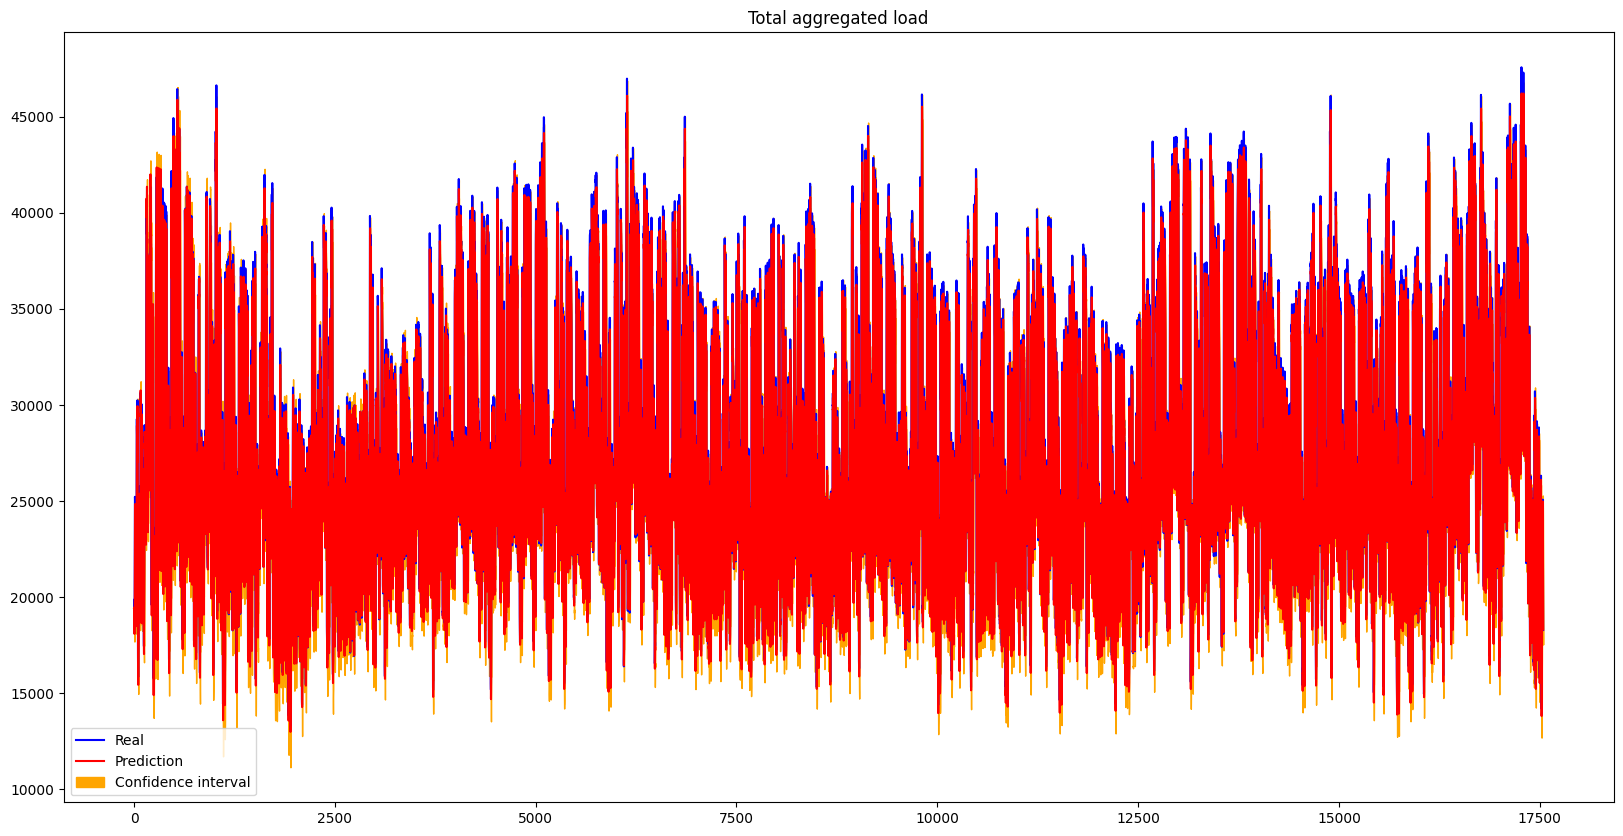

In [33]:
#plot_preds_vs_actual(res.y_true, res.y_pred)
plt.figure(figsize=(20,10))
plt.title("Total aggregated load", color="black")

plt.plot(res.index,
         res.y_true,
         color='Blue',
         label="Real")

plt.plot(res.index,
         res.y_pred,
         label="Prediction",
         color="red")

plt.fill_between(x=res.index,
                 y1=res.upper_ci_bound,
                 y2=res.lower_ci_bound,
                 color='orange',
                 label="Confidence interval",
                 alpha=1)

plt.legend()